In [1]:
__depends__ = ["/Volumes/Seagate Expansion Drive/seq1_jcole_gene-editing_gene-editing_multiple/multiple"]
__dest__ = []

In [18]:
%matplotlib inline

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default')
import statsmodels.api as sm
import itertools
import numpy as np
import seaborn as sns

In [20]:
plt.rcdefaults()
# Typeface sizes
from matplotlib import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern Roman']
#rcParams['text.usetex'] = True

# Optimal figure size
WIDTH = 350.0  # the number latex spits out
FACTOR = 0.90  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims      = [fig_width_in, fig_height_in] # fig dims as a list

rcParams['figure.figsize'] = fig_dims

First, let's load the results from the small model of polled included in the default settings. This involves loading four animal files (live cows, dead cows, live bulls, and dead bulls). We will load them and merge them into a single data frame.

In [21]:
methods = ['crispr', 'noedits', 'perfect', 'talen', 'zfn']
for method in methods:
    print method
    # We have 10 replicates for each simulation
    for sim in xrange(1,11):
        if sim == 1: print '\tReplicate: ', sim,
        elif sim < 10: print ', ', sim,
        else: print ', ', sim, ''
        # Load the individual history files
        lc = pd.read_csv('multiple/01_00/%s/%s/cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        dc = pd.read_csv('multiple/01_00/%s/%s/dead_cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        lb = pd.read_csv('multiple/01_00/%s/%s/bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        db = pd.read_csv('multiple/01_00/%s/%s/dead_bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        # Stack the individual animal datasets
        all_animals = pd.concat([lc, dc, lb, db], axis=0)
        all_animals['replicate'] = sim
        all_animals['method'] = method
    if method == methods[0]:
        grouped = pd.crosstab(all_animals['died'], all_animals['cause']).apply(lambda r: r/r.sum(), axis=1)
        grouped['method'] = method
    else:
        temp_grouped = pd.crosstab(all_animals['died'], all_animals['cause']).apply(lambda r: r/r.sum(), axis=1)
        temp_grouped['method'] = method
        grouped = pd.concat([grouped, temp_grouped])

crispr
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
noedits
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8

KeyboardInterrupt: 

Modified Pryce's Algorithm
====
Causes of death (A=culled for age, N=culled for population size, R=died from recessive)

In [14]:
grouped.head()

cause,A,G,N,R,method
died,,,,,
1,0.000000,0.007394,0.983652,0.008954,crispr
2,0.213105,0.006154,0.779233,0.001508,crispr
3,0.164407,0.006837,0.827500,0.001256,crispr
4,0.067911,0.003987,0.926579,0.001523,crispr
5,0.049322,0.003984,0.945632,0.001061,crispr


In [15]:
grouped.reset_index(inplace=True)

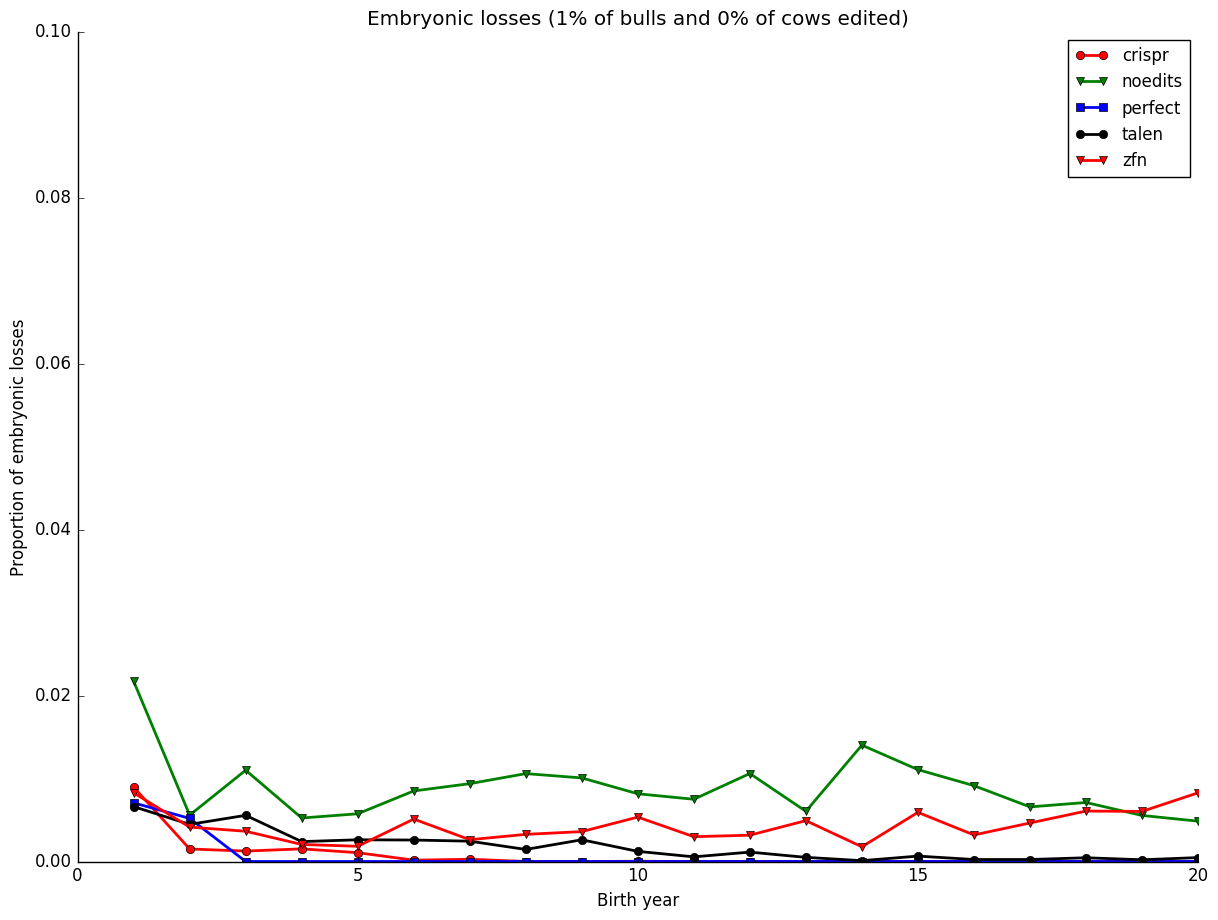

In [17]:
fig = plt.figure(figsize=(12, 9), dpi=300, facecolor='white')

# Set nicer limits
ymin ,ymax = 0, 0.10
xmin, xmax = 0, 31

colors = itertools.cycle(['r', 'g', 'b','k'])
markers = itertools.cycle(['o', 'v', 's'])

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Embryonic losses (1% of bulls and 0% of cows edited)')
ax.set_xlabel('Birth year')
ax.set_ylabel('Proportion of embryonic losses')
ax.plot(grouped['died'][grouped['method']=='crispr'], grouped['R'][grouped['method']=='crispr'], label='crispr', linewidth=2, marker=markers.next(), c=colors.next())
ax.plot(grouped['died'][grouped['method']=='noedits'], grouped['R'][grouped['method']=='noedits'], label='noedits', linewidth=2, marker=markers.next(), c=colors.next())
ax.plot(grouped['died'][grouped['method']=='perfect'], grouped['R'][grouped['method']=='perfect'], label='perfect', linewidth=2, marker=markers.next(), c=colors.next())
ax.plot(grouped['died'][grouped['method']=='talen'], grouped['R'][grouped['method']=='talen'], label='talen', linewidth=2, marker=markers.next(), c=colors.next())
ax.plot(grouped['died'][grouped['method']=='zfn'], grouped['R'][grouped['method']=='zfn'], label='zfn', linewidth=2, marker=markers.next(), c=colors.next())
ax.legend(loc='best')

ax.set_ylim(ymin, ymax)

# Despine
ax = fig.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Plot and save
fig.tight_layout(pad=0.1)  # Make the figure use all available whitespace
fig.savefig('multiple/01_00/embryonic losses_01_00.png', dpi=300)
plt.show()

Can we figure out how many possible at-risk matings there were per generation?
====
I *think* that the easiest way to do that is to identify the bulls and cows that actually were used as mates, and count the number of carriers in that group per generation, and then take the product of those two numbers.

Animal records are laid out as follows:
 * 0  = animal ID
 * 1  = sire ID
 * 2  = dam ID
 * 3  = time (generation) born
 * 4  = sex of calf
 * 5  = herd in which calf was born
 * 6  = alive/dead flag
 * 7  = reason for death
 * 8  = time (generation) died
 * 9  = true breeding value
 * 10 = coefficient of inbreeding
 * 11 = edit status (have recessives been edited)
 * 12 = recessive genotypes

In [10]:
methods = ['crispr', 'noedits', 'perfect', 'talen', 'zfn']
for method in methods:
    print method
    # We have 10 replicates for each simulation
    for sim in xrange(1,11):
        if sim == 1: print '\tReplicate: ', sim,
        elif sim < 10: print ', ', sim,
        else: print ', ', sim, ''
        # Load the individual history files
        lc = pd.read_csv('multiple/01_00/%s/%s/cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        dc = pd.read_csv('multiple/01_00/%s/%s/dead_cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        lb = pd.read_csv('multiple/01_00/%s/%s/bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        db = pd.read_csv('multiple/01_00/%s/%s/dead_bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        # Stack the individual animal datasets
        all_animals = pd.concat([lc, dc, lb, db], axis=0)
        all_animals['replicate'] = sim
        all_animals['method'] = method
        # Select only the rows where the animal was either the sire or a dam of another animal in the dataset.
        all_animals = all_animals[(all_animals['animal'].isin(all_animals['sire'])) | (all_animals['animal'].isin(all_animals['dam']))]            
        all_animals['r_count'] = all_animals['recessives'].apply(np.count_nonzero, axis=1)
    if method == methods[0]:
        grouped = pd.crosstab(all_animals['born'], [all_animals['r_count'], all_animals['sex']])#.apply(lambda r: r/r.sum(), axis=1)
        grouped['method'] = method
    else:
        temp_grouped = pd.crosstab(all_animals['born'], [all_animals['r_count'], all_animals['sex']])#.apply(lambda r: r/r.sum(), axis=1)
        temp_grouped['method'] = method
        grouped = pd.concat([grouped, temp_grouped])


crispr
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
noedits
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
perfect
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
talen
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
zfn
	Replicate:  1

KeyboardInterrupt: 

In [38]:
grouped.reset_index(drop=True, inplace=True)

In [44]:
grouped.columns = grouped.columns.get_level_values(0)
grouped.columns = ['born', 'carrier_dams', 'carrier_sires', 'method']
grouped.head()

,born,carrier_dams,carrier_sires,method
0,-9,0,6,crispr
1,-8,0,2,crispr
2,-7,0,7,crispr
3,-6,0,4,crispr
4,-5,0,6,crispr


In [45]:
grouped['at_risk'] = grouped['carrier_dams'] * grouped['carrier_sires']

In [47]:
grouped.head(10)

,born,carrier_dams,carrier_sires,method,at_risk
0,-9,0,6,crispr,0
1,-8,0,2,crispr,0
2,-7,0,7,crispr,0
3,-6,0,4,crispr,0
4,-5,0,6,crispr,0
5,-4,7059,6,crispr,42354
6,-3,6992,7,crispr,48944
7,-2,6931,3,crispr,20793
8,-1,6999,7,crispr,48993
9,0,7019,3,crispr,21057


In [49]:
grouped['risk_pct'] = grouped['at_risk'] / grouped['at_risk'].sum(axis=0)

In [72]:
grouped.head(10)

,born,carrier_dams,carrier_sires,method,at_risk,risk_pct
0,-9,0,6,crispr,0,0.000000
1,-8,0,2,crispr,0,0.000000
2,-7,0,7,crispr,0,0.000000
3,-6,0,4,crispr,0,0.000000
4,-5,0,6,crispr,0,0.000000
5,-4,7059,6,crispr,42354,0.000143
6,-3,6992,7,crispr,48944,0.000165
7,-2,6931,3,crispr,20793,0.000070
8,-1,6999,7,crispr,48993,0.000165
9,0,7019,3,crispr,21057,0.000071


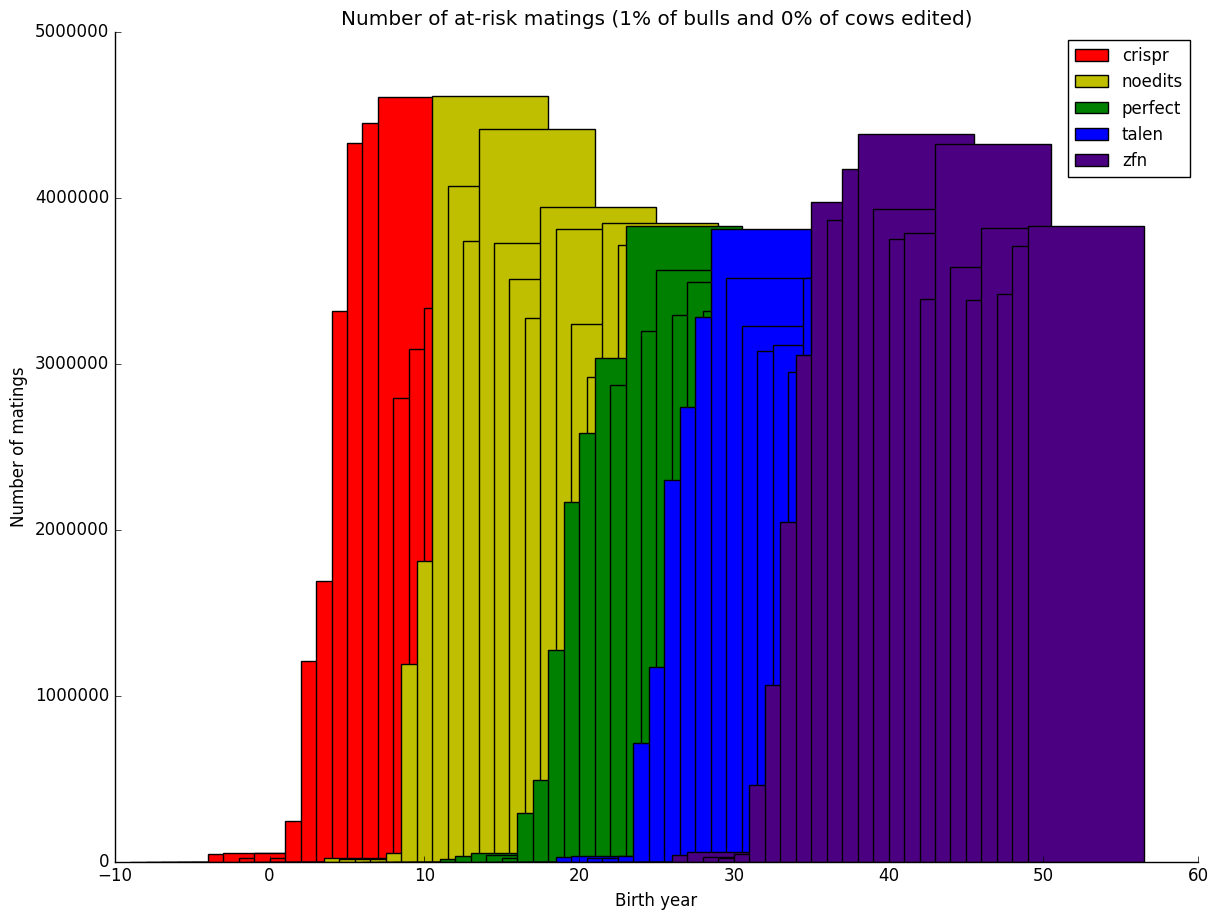

In [86]:
fig = plt.figure(figsize=(12, 9), dpi=300, facecolor='white')

# Set nicer limits
#ymin ,ymax = 0, 0.10
xmin, xmax = 0, 31

colors = itertools.cycle(['r', 'y', 'g', 'b', 'indigo'])
markers = itertools.cycle(['o', 'v', 's'])
bwidth = 7.5

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Number of at-risk matings (1% of bulls and 0% of cows edited)')
ax.set_xlabel('Birth year')
ax.set_ylabel('Number of matings')
r1 = ax.bar(grouped['born'][grouped['method']=='crispr'], grouped['at_risk'][grouped['method']=='crispr'], 
       width=bwidth, label='crispr', color=colors.next())
r2 = ax.bar(grouped['born'][grouped['method']=='noedits']+bwidth, grouped['at_risk'][grouped['method']=='noedits'],
       width=bwidth, label='noedits', color=colors.next())
r3 = ax.bar(grouped['born'][grouped['method']=='perfect']+(2*bwidth), grouped['at_risk'][grouped['method']=='perfect'], 
       width=bwidth, label='perfect', color=colors.next())
r4 = ax.bar(grouped['born'][grouped['method']=='talen']+(3*bwidth), grouped['at_risk'][grouped['method']=='talen'],
       width=bwidth, label='talen', color=colors.next())
r5 = ax.bar(grouped['born'][grouped['method']=='zfn']+(4*bwidth), grouped['at_risk'][grouped['method']=='zfn'],
       width=bwidth, label='zfn', color=colors.next())
ax.legend(loc='best')

#ax.set_ylim(ymin, ymax)

# Despine
ax = fig.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Plot and save
fig.tight_layout(pad=0.1)  # Make the figure use all available whitespace
#fig.savefig('./results/embryonic losses_01_00.png', dpi=300)
plt.show()